In [1]:
import pandas as pd
import os
import glob
import numpy as np
import statistics as stats
import scipy
import src.mpra_tools.predicted_occupancy as po
import src.mpra_tools.fasta_utils as fu
import math
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import random
from Ensembl_converter import EnsemblConverter
import requests, sys

## Change Ennsembl ID to Common Name.  The Cross Reference with known TF in mouse
### For the purpose of identifying immportant words/motifs in sentence construction

In [2]:
activity_df = pd.read_csv("Data/activity.csv", index_col=0)
retinopathy_df = pd.read_csv("Data/retinopathy.csv", index_col=0)
L = 164

In [3]:
motif_df = pd.read_parquet("Data/Motifs/summarized_all_motifs.parquet")
TFs = list(set(motif_df['motif']))

In [4]:
rna_seq = pd.read_csv("Data/RNA/WT2_run1/quant.sf", sep='\t', index_col=0)
run = "WT2_run1"
expressed = rna_seq[rna_seq['TPM'] > 0.0]
new_index = [i.split('.')[0] for i in expressed.index]
expressed.index = new_index
gene_info = pd.read_csv("Data/RNA/" + run + "/gene_info.csv", index_col=0)
gene_info['display_name'] = gene_info['display_name'].map(lambda x : x.split('-')[0].upper())

/tmp/ipykernel_2314952/1564735543.py:6: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  gene_info = pd.read_csv("Data/RNA/" + run + "/gene_info.csv", index_col=0)


In [5]:
protein_info = gene_info[(gene_info['biotype']=='protein_coding') & (gene_info['display_name'] != 'MT')]

TF_info = protein_info[protein_info['display_name'].isin(TFs)]
TF_info = TF_info[TF_info.index.isin(expressed.index)].copy()

In [6]:
expressed_TF = expressed[expressed.index.isin(TF_info.index)].copy()
expressed_TF['Motif'] = TF_info['display_name']

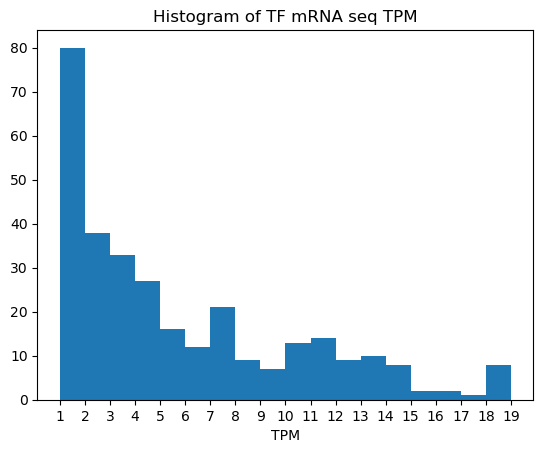

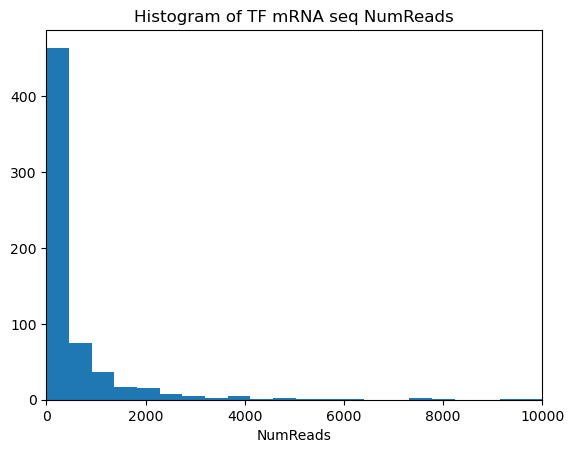

In [30]:


plt.hist(expressed_TF['TPM'], bins = np.arange(1,20))
plt.title("Histogram of TF mRNA seq TPM")
plt.xlabel("TPM")
plt.xticks(np.arange(1,20))
plt.show()

plt.clf()
plt.hist(expressed_TF['NumReads'], bins = 100)
plt.title("Histogram of TF mRNA seq NumReads")
plt.xlabel("NumReads")
#plt.xticks(np.arange(1,20))
plt.xlim(0,10000)
plt.show()

In [32]:
gene_info

,seq_region_name,assembly_name,id,species,length,logic_name,end,version,display_name,object_type,biotype,is_canonical,strand,start,db_type,Parent,source
ENSMUST00000159530,1,GRCm39,ENSMUST00000159530,mus_musculus,898,havana_mus_musculus,6344713,2,RB1CC1,Transcript,protein_coding,0,1,6333157,core,ENSMUSG00000025907,havana
ENSMUST00000162418,1,GRCm39,ENSMUST00000162418,mus_musculus,2150,havana_mus_musculus,6342989,2,RB1CC1,Transcript,retained_intron,0,1,6335830,core,ENSMUSG00000025907,havana
ENSMUST00000115480,1,GRCm39,ENSMUST00000115480,mus_musculus,1676,havana_tagene_mus_musculus,9701395,9,2610203C22RIK,Transcript,lncRNA,0,-1,9630705,core,ENSMUSG00000079671,havana_tagene
ENSMUST00000188486,1,GRCm39,ENSMUST00000188486,mus_musculus,3748,havana_mus_musculus,9969399,2,SGK3,Transcript,retained_intron,0,1,9965652,core,ENSMUSG00000025915,havana
ENSMUST00000192427,1,GRCm39,ENSMUST00000192427,mus_musculus,899,havana_mus_musculus,4056207,2,GM37381,Transcript,lncRNA,1,-1,4054448,core,ENSMUSG00000102343,havana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUST00000238471,Y,GRCm39,ENSMUST00000238471,mus_musculus,3347,havana_mus_musculus,90827734,2,ERDR1Y,Transcript,lncRNA,1,1,90801720,core,ENSMUSG00000096768,havana
ENSMUST00000082421,MT,GRCm39,ENSMUST00000082421,mus_musculus,1144,mt_genbank_import_mus_musculus,15288,1,MT,Transcript,protein_coding,1,1,14145,core,ENSMUSG00000064370,RefSeq
ENSMUST00000082397,MT,GRCm39,ENSMUST00000082397,mus_musculus,67,mt_genbank_import_mus_musculus,5016,1,MT,Transcript,Mt_tRNA,1,1,4950,core,ENSMUSG00000064346,RefSeq
ENSMUST00000179483,Y,GRCm39,ENSMUST00000179483,mus_musculus,696,ensembl_havana_transcript_mus_musculus,90827716,9,ERDR1Y,Transcript,lncRNA,0,1,90796007,core,ENSMUSG00000096768,ensembl_havana
